### Download dataset

In [1]:
import gdown

In [3]:
url = 'https://drive.google.com/u/0/uc?id=157bjO1_cFuSd0HWDUuAmcHRJDVyWpOxB&export=download'
output = 'LOLdataset.zip'
#gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?id=157bjO1_cFuSd0HWDUuAmcHRJDVyWpOxB&export=download
To: /mnt/batch/tasks/shared/LS_root/mounts/clusters/main-comp/code/Users/ALBERTO.Moreno/LOLdataset.zip
347MB [00:03, 106MB/s] 


'LOLdataset.zip'

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import os
from glob import glob
from PIL import Image
from utils import *
from tqdm import tqdm

### Load

In [2]:
train_low_data = []
train_high_data = []

train_low_data_names = glob('./our485/low/*.png')
train_low_data_names.sort()
train_high_data_names = glob('./our485/high/*.png')
train_high_data_names.sort()
assert len(train_low_data_names) == len(train_high_data_names)
print('[*] Number of training data: %d' % len(train_low_data_names))

for idx in tqdm(range(len(train_low_data_names))):
    low_im = load_images(train_low_data_names[idx])
    high_im = load_images(train_high_data_names[idx])
    
    for i in range(3):
        for j in range(3):
            mode = np.random.choice(np.arange(6))
            train_low_data.append(data_augmentation(low_im,mode)[128*i:128*(i+1),128*j:128*(j+1)])
            train_high_data.append(data_augmentation(high_im,mode)[128*i:128*(i+1),128*j:128*(j+1)])
    
train_low_data, train_high_data = shuffle(np.array(train_low_data), np.array(train_high_data))

[*] Number of training data: 485


100%|██████████| 485/485 [01:06<00:00,  7.29it/s]


### Create decom_net model

In [3]:
chanel = 64
kernel = 3

In [4]:
inp = tf.keras.layers.Input((128, 128, 3))
x = tf.keras.layers.Conv2D(chanel, kernel, activation='relu', padding="same")(inp)
x = tf.keras.layers.Conv2D(chanel, kernel, activation='relu', padding="same")(x)
x = tf.keras.layers.Conv2D(chanel, kernel, activation='relu', padding="same")(x)
x = tf.keras.layers.Conv2D(chanel, kernel, activation='relu', padding="same")(x)
x = tf.keras.layers.Conv2D(4, kernel, activation='sigmoid', padding="same")(x)

decom_net = tf.keras.Model(inp, x)

In [5]:
decom_net.load_weights('./models/decom_net_checkpoint')

In [8]:
class DecomNetSisters(tf.keras.Model):
    def __init__(self, decom_net):
        super(DecomNetSisters, self).__init__()
        self.decom_net = decom_net

    def call(self, images):
        return self.decom_net(images[0]),self.decom_net(images[1])
    
    def train_step(self, images):
        
        with tf.GradientTape() as tape:
            out_l = self.decom_net(images[0][0])
            out_h = self.decom_net(images[0][1])
            
            recon_loss_low = tf.reduce_mean(tf.abs(out_l[:,:,:,:3] * out_l[:,:,:,3:4] -  images[0][0]))
            recon_loss_high = tf.reduce_mean(tf.abs(out_h[:,:,:,:3] * out_h[:,:,:,3:4] -  images[0][1]))
            recon_loss_mutal_low = tf.reduce_mean(tf.abs(out_l[:,:,:,3:4] * out_h[:,:,:,:3] - images[0][0]))
            recon_loss_mutal_high = tf.reduce_mean(tf.abs(out_h[:,:,:,3:4] * out_l[:,:,:,:3] - images[0][1]))
            equal_R_loss = tf.reduce_mean(tf.abs(out_l[:,:,:,3:4] - out_h[:,:,:,3:4]))
            
            loss = recon_loss_low+recon_loss_high+recon_loss_mutal_low*0.001+recon_loss_mutal_high*0.001+equal_R_loss*0.01
        
        tr_vars = self.trainable_variables
        grads = tape.gradient(loss,tr_vars)
        self.optimizer.apply_gradients(zip(grads,tr_vars))

        return {"loss":loss}

In [9]:
dcom_model = DecomNetSisters(decom_net)

In [10]:
dcom_model.compile(optimizer='Adam')

### Train decomp net

In [15]:
dcom_model.fit([train_low_data,train_high_data],epochs=3,batch_size=100)

Epoch 1/3
44/44 [==============================] - 548s 12s/step - loss: 0.1728
Epoch 2/3
44/44 [==============================] - 547s 12s/step - loss: 0.0587
Epoch 3/3
44/44 [==============================] - 597s 14s/step - loss: 0.0521


In [21]:
dcom_model.fit([train_low_data,train_high_data],epochs=3,batch_size=300)

Epoch 1/3
15/15 [==============================] - 523s 35s/step - loss: 0.0372
Epoch 2/3
15/15 [==============================] - 527s 35s/step - loss: 0.0348
Epoch 3/3
15/15 [==============================] - 523s 35s/step - loss: 0.0336


### Decom Results

In [57]:
decom_net.save_weights('./models/decom_net_checkpoint')

In [21]:
decom_pred = dcom_model.predict([train_low_data[:10],train_high_data[:10]])

In [130]:
i=1

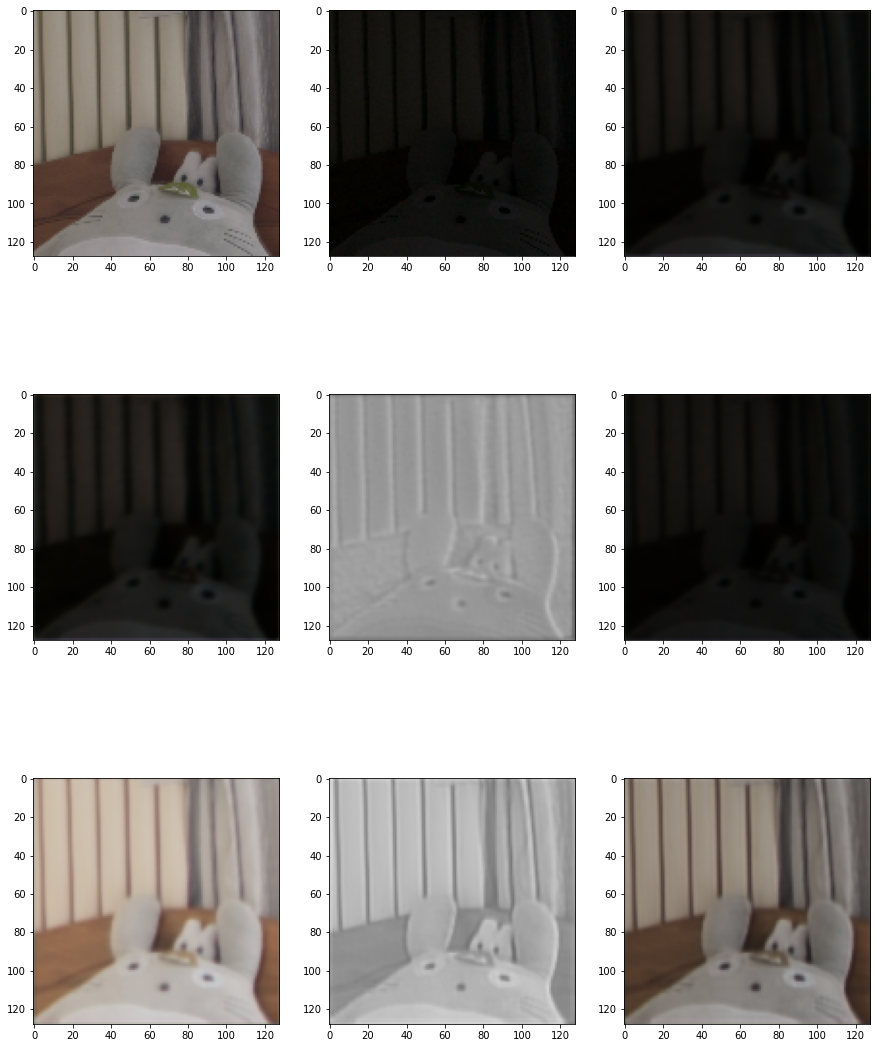

In [131]:
fig, axs = plt.subplots(3,3,figsize=(15, 20))

axs[0,0].imshow(np.array(train_high_data[:10])[i])
axs[0,1].imshow(np.array(train_low_data[:10])[i])

axs[1,0].imshow(decom_pred[0][i][:,:,:3],vmin=0, vmax=1)
axs[1,1].imshow(decom_pred[0][i][:,:,3],cmap="gray",vmin=0, vmax=1)
axs[1,2].imshow(decom_pred[0][i][:,:,3:]*b[0][i][:,:,:3],vmin=0, vmax=1)

axs[2,0].imshow(decom_pred[1][i][:,:,:3],vmin=0, vmax=1)
axs[2,1].imshow(decom_pred[1][i][:,:,3],cmap="gray",vmin=0, vmax=1)
axs[2,2].imshow(decom_pred[1][i][:,:,3:]*b[1][i][:,:,:3],vmin=0, vmax=1)

axs[0,2].imshow(decom_pred[0][i][:,:,:3]*b[1][i][:,:,3:4],vmin=0, vmax=1)


### Proposed enhancement

In [14]:
uconv_inp = tf.keras.layers.Input((128, 128, 4))

x_down1_u = tf.keras.layers.Conv2D(chanel, kernel, activation='relu', strides=2, padding="same")(uconv_inp)
x_down2_u = tf.keras.layers.Conv2D(chanel, kernel, activation='relu', strides=2, padding="same")(x_down1_u)
x_down3_u = tf.keras.layers.Conv2D(chanel, kernel, activation='relu', strides=2, padding="same")(x_down2_u)
x_down4_u = tf.keras.layers.Conv2D(chanel, kernel, activation='relu', strides=2, padding="same")(x_down3_u)

x_up1_u = tf.keras.layers.UpSampling2D(size=2)(x_down4_u)
x_up1_u = tf.keras.layers.Concatenate()([x_up1_u,x_down3_u])
x_up1_u = tf.keras.layers.Conv2D(chanel, kernel, activation='relu', padding="same")(x_up1_u)

x_up2_u = tf.keras.layers.UpSampling2D(size=2)(x_up1_u)
x_up2_u = tf.keras.layers.Concatenate()([x_up2_u,x_down2_u])
x_up2_u = tf.keras.layers.Conv2D(chanel, kernel, activation='relu', padding="same")(x_up2_u)

x_up3_u = tf.keras.layers.UpSampling2D(size=2)(x_up2_u)
x_up3_u = tf.keras.layers.Concatenate()([x_up3_u,x_down1_u])
x_up3_u = tf.keras.layers.Conv2D(chanel, kernel, activation='relu', padding="same")(x_up3_u)

x_up4_u = tf.keras.layers.UpSampling2D(size=2)(x_up3_u)
x_up4_u = tf.keras.layers.Concatenate()([x_up4_u,uconv_inp])
x_up4_u = tf.keras.layers.Conv2D(chanel, kernel, activation='relu', padding="same")(x_up4_u)

uconv_out = tf.keras.layers.Conv2D(1, kernel, padding='same', activation='sigmoid')(x_up4_u)

uconv = tf.keras.Model(uconv_inp, uconv_out)

In [15]:
uconv.compile(optimizer="adam",loss=tf.keras.losses.MeanSquaredError())

In [ ]:
uconv.load_weights('./models/uconv_net_checkpoint')

### Get training data

In [16]:
decom_low = decom_net.predict(train_low_data)

In [17]:
decom_high = decom_net.predict(train_high_data)
decom_high = decom_high[:,:,:,3:4]

### Train

In [ ]:
uconv.fit(decom_low,decom_high,epochs=10,batch_size=100)

Epoch 1/10
25/44 [================>.............] - ETA: 1:36 - loss: 0.0092

In [125]:
uconv.save_weights('./models/uconv_net_checkpoint')

In [19]:
enhancement_pred = uconv.predict(decom_low[:10])

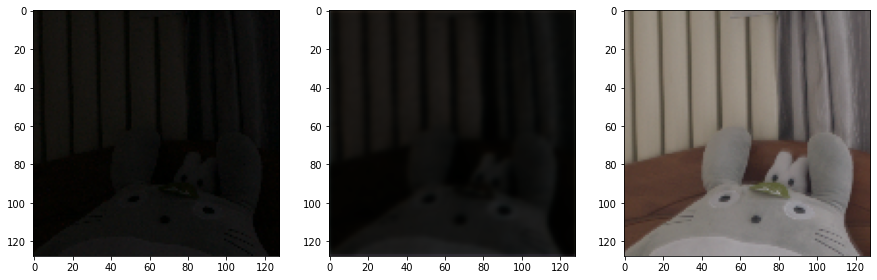

In [132]:
fig, axs = plt.subplots(1,3,figsize=(15, 20))
axs[1].imshow(b[0][i][:,:,:3]*enhancement_pred[i])
axs[0].imshow(train_low_data[i])


imageObject = Image.fromarray(np.uint8((decom_pred[0][i][:,:,:3]*enhancement_pred[i])));

#sharpened1 = imageObject.filter(ImageFilter.SHARPEN);
axs[1].imshow(decom_pred[0][i][:,:,:3]*enhancement_pred[i])

axs[2].imshow(train_high_data[i])

### Some tests

In [25]:
uconv_inp_test = tf.keras.layers.Input((128, 128, 4))

x_down1_u_test = tf.keras.layers.Conv2D(chanel, kernel, activation='relu', strides=2, padding="same")(uconv_inp_test)
x_down2_u_test = tf.keras.layers.Conv2D(chanel, kernel, activation='relu', strides=2, padding="same")(x_down1_u_test)
x_down3_u_test = tf.keras.layers.Conv2D(chanel, kernel, activation='relu', strides=2, padding="same")(x_down2_u_test)
x_down4_u_test = tf.keras.layers.Conv2D(chanel, kernel, activation='relu', strides=2, padding="same")(x_down3_u_test)

x_up1_u_test = tf.keras.layers.UpSampling2D(size=2)(x_down4_u_test)
x_up1_u_test = tf.keras.layers.Concatenate()([x_up1_u_test,x_down3_u_test])
x_up1_u_test = tf.keras.layers.Conv2D(chanel, kernel, activation='relu', padding="same")(x_up1_u_test)

x_up2_u_test = tf.keras.layers.UpSampling2D(size=2)(x_up1_u_test)
x_up2_u_test = tf.keras.layers.Concatenate()([x_up2_u_test,x_down2_u_test])
x_up2_u_test = tf.keras.layers.Conv2D(chanel, kernel, activation='relu', padding="same")(x_up2_u_test)

x_up3_u_test = tf.keras.layers.UpSampling2D(size=2)(x_up2_u_test)
x_up3_u_test = tf.keras.layers.Concatenate()([x_up3_u_test,x_down1_u_test])
x_up3_u_test = tf.keras.layers.Conv2D(chanel, kernel, activation='relu', padding="same")(x_up3_u_test)

x_up4_u_test = tf.keras.layers.UpSampling2D(size=2)(x_up3_u_test)
x_up4_u_test = tf.keras.layers.Concatenate()([x_up4_u_test,uconv_inp_test])
x_up4_u_test = tf.keras.layers.Conv2D(chanel, kernel, activation='relu', padding="same")(x_up4_u_test)

uconv_out_test = tf.keras.layers.Conv2D(3, kernel, padding='same', activation='sigmoid')(x_up4_u_test)

uconv_test = tf.keras.Model(uconv_inp_test, uconv_out_test)

In [26]:
uconv_test.compile(optimizer="adam",loss=tf.keras.losses.MeanSquaredError())

In [ ]:
uconv_test.load_weights('./models/uconv_net_test_checkpoint')

In [27]:
decom_low = decom_net.predict(train_low_data)

In [ ]:
uconv_test.fit(decom_low,train_high_data,epochs=10,batch_size=100)

In [126]:
uconv_test.save_weights('./models/uconv_net_test_checkpoint')

In [57]:
enhancement_test_pred = uconv_test.predict(decom_low[:10])

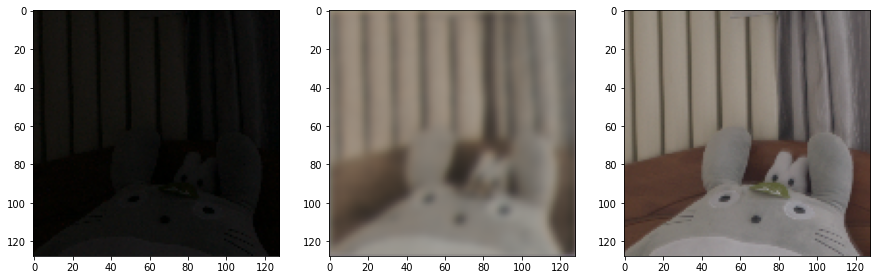

In [133]:
fig, axs = plt.subplots(1,3,figsize=(15, 20))

axs[0].imshow(train_low_data[i])

axs[1].imshow(enhancement_test_pred[i])
axs[2].imshow(train_high_data[i])

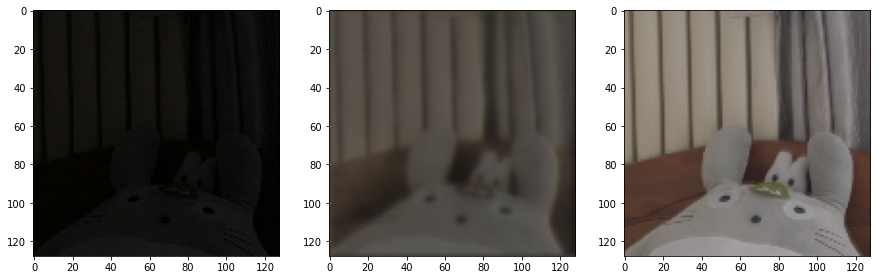

In [134]:
fig, axs = plt.subplots(1,3,figsize=(15, 20))

axs[0].imshow(train_low_data[i])

axs[1].imshow((decom_pred[0][i][:,:,3:])*enhancement_test_pred[i][:])
axs[2].imshow(train_high_data[i])

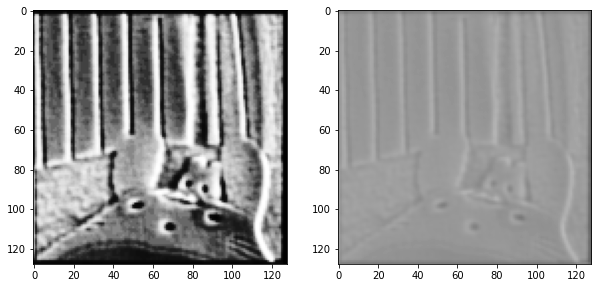

In [135]:
import cv2

equ = cv2.equalizeHist((decom_pred[0][i][:,:,3:]*255).astype(np.uint8))

fig, axs = plt.subplots(1,2,figsize=(10, 20))

axs[0].imshow(equ,cmap="gray",vmin=0, vmax=255)
axs[1].imshow(decom_pred[0][i][:,:,3],cmap="gray",vmin=0, vmax=1)

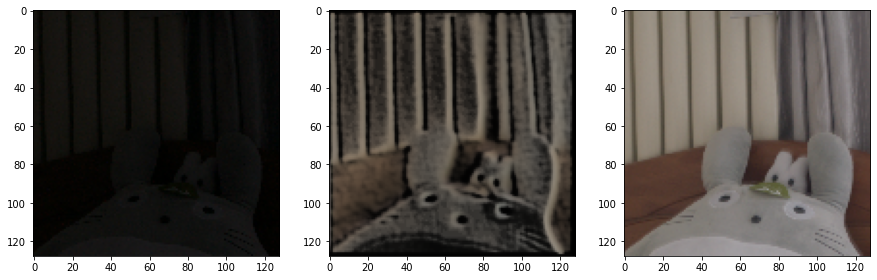

In [136]:
fig, axs = plt.subplots(1,3,figsize=(15, 20))

axs[0].imshow(train_low_data[i])
axs[1].imshow(( np.expand_dims(equ, axis=-1)/255)*enhancement_test_pred[i][:])
axs[2].imshow(train_high_data[i])